In [1]:
import pandas as pd
import numpy as np

In [2]:
df_csv_bio = pd.read_csv('data/sequences_bio_clean_alignment_filtro.csv', sep=',')


### Vectorización por indexado

In [3]:
all_chars = "".join(df_csv_bio["alignment"].tolist())

unique_chars = sorted(set(all_chars))

map_dict = {ch: i for i, ch in enumerate(unique_chars)}
print("Diccionario de mapeo:", map_dict)

df_csv_bio["sequence_20_cod"] = df_csv_bio["alignment"].apply(
    lambda seq: [map_dict[ch] for ch in seq]
)

#Para usar la secuencia original, descomentar la siguiente línea y comentar la anterior
# df_csv_bio["sequence_20_cod"] = df_csv_bio["sequence_20"].apply(
#     lambda seq: [map_dict[ch] for ch in seq]
# )

Diccionario de mapeo: {'-': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'X': 20, 'Y': 21}


In [4]:
from sklearn.decomposition import PCA
import plotly.express as px

### Visualización usando PCA

In [5]:
seq_embeddings = np.array(df_csv_bio["sequence_20_cod"].to_list())

In [6]:
pca = PCA(n_components=4)
embedding_pca = pca.fit_transform(seq_embeddings)

fig = px.scatter(
    x=embedding_pca[:, 0],
    y=embedding_pca[:, 1],
    color=df_csv_bio['Species Family'].to_list(),
    title="PCA de embeddings indexado de proteínas por especie",
    labels={"x": "PCA1", "y": "PCA2"},
    hover_data=[df_csv_bio['Peptide_Family']]
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color="DarkSlateGrey")))
fig.show()

/Users/pablo1n7/miniconda3/envs/vasija/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [7]:
fig = px.scatter(
    x=embedding_pca[:, 0],
    y=embedding_pca[:, 1],
    color=df_csv_bio['Peptide_Family'].to_list(),
    title="PCA de embeddings indexado de proteínas por familia de péptidos",
    labels={"x": "PCA0", "y": "PCA1"}
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color="DarkSlateGrey")))
fig.show()

/Users/pablo1n7/miniconda3/envs/vasija/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [8]:

df_plot = pd.DataFrame({
    "PC1": embedding_pca[:, 0],
    "PC2": embedding_pca[:, 1],
    "PC3": embedding_pca[:, 2],
    "Peptide_Family": df_csv_bio['Peptide_Family'].to_list(),
    "Family": df_csv_bio['Species Family'].to_list(),
    "seq_id": df_csv_bio.get('seq_id', [f"Seq{i+1}" for i in range(len(embedding_pca))]),
    "sequence_20": df_csv_bio.get('sequence_20', None)
})

fig = px.scatter_3d(
    df_plot,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Peptide_Family",
    hover_name="seq_id",
    hover_data={"sequence_20": True, "Family": True, "PC1": False, "PC2": False, "PC3": False},
    title="PCA 3D de embeddings indexado de proteínas por familia de péptidos",
    labels={"PC1": "PCA0", "PC2": "PCA1", "PC3": "PCA2"},
)

fig.update_traces(marker=dict(size=6, line=dict(width=0.5)), selector=dict(mode='markers'))
fig.show()




/Users/pablo1n7/miniconda3/envs/vasija/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [9]:
from scipy.spatial.distance import pdist, squareform
from skbio import DistanceMatrix
from skbio.stats.distance import permanova


### PERMANOVA entre todos los grupos de péptidos

In [10]:
groups = np.array(df_csv_bio['Peptide_Family'].to_list())

X = np.array(seq_embeddings)

dists = squareform(pdist(X, metric='euclidean'))

dm = DistanceMatrix(dists, ids=[f"s{i}" for i in range(len(seq_embeddings))])
metadata = pd.DataFrame({"group": groups}, index=dm.ids)

res_perm = permanova(dm, metadata, column='group', permutations=999)
print(res_perm)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1334
number of groups                 12
test statistic            21.742462
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [11]:
import itertools

### PERMANOVA entre pares de familia de péptidos

In [12]:
unique_groups = np.unique(groups)

pairwise_results = []

for g1, g2 in itertools.combinations(unique_groups, 2):
    idx = metadata['group'].isin([g1, g2])
    
    sub_dm = dm.filter(metadata.index[idx])
    sub_meta = metadata.loc[idx]
    
    res = permanova(sub_dm, sub_meta, column='group', permutations=999)
    
    pairwise_results.append({
        'group1': g1,
        'group2': g2,
        'pseudo-F': res['test statistic'],
        'p-value': res['p-value']
    })

pairwise_df = pd.DataFrame(pairwise_results)
print(pairwise_df)

          group1       group2    pseudo-F  p-value
0       Amolopin     Brevinin    2.680107    0.026
1       Amolopin  Dermaseptin  140.152295    0.001
2       Amolopin   Esculentin   12.232416    0.001
3       Amolopin     Gaegurin    8.381447    0.001
4       Amolopin     Nigrocin    5.384444    0.001
..           ...          ...         ...      ...
61  Phylloseptin      Rugosin  227.593587    0.001
62  Phylloseptin     Temporin   19.493033    0.001
63    Ranatuerin      Rugosin   11.627931    0.001
64    Ranatuerin     Temporin    7.252559    0.004
65       Rugosin     Temporin    7.659908    0.002

[66 rows x 4 columns]


In [13]:
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

### Ajustar *p_values* con FDR (Benjamini-Hochberg)

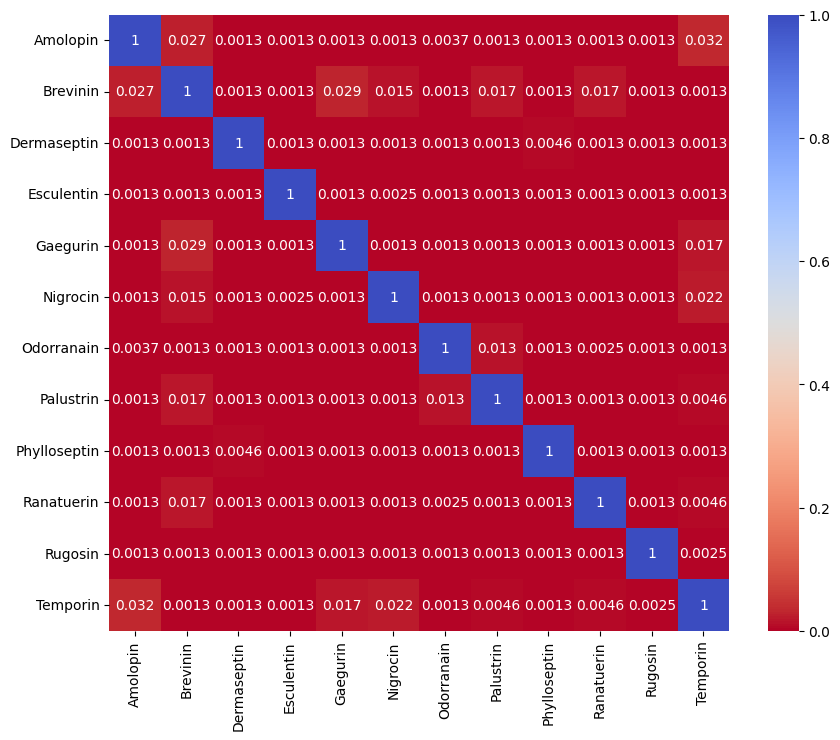

In [14]:

reject, pvals_corrected, _, _ = multipletests(pairwise_df['p-value'], method='fdr_bh')
pairwise_df['p-value_adj'] = pvals_corrected
pairwise_df['significant'] = reject

pval_matrix = pd.DataFrame(np.ones((len(unique_groups), len(unique_groups))),
                           index=unique_groups, columns=unique_groups)

for _, row in pairwise_df.iterrows():
    pval_matrix.loc[row['group1'], row['group2']] = row['p-value_adj']
    pval_matrix.loc[row['group2'], row['group1']] = row['p-value_adj']

plt.figure(figsize=(10,8))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm_r', vmin=0, vmax=1)

plt.savefig('fig/permanova/indexado_alineacion_permanova_heatmap.png')

#descomentar la siguiente línea para guardar el heatmap de la secuencia
#plt.savefig('fig/permanova/indexado_secuencia_permanova_heatmap.png')

In [15]:
import matplotlib.ticker as mticker


<Figure size 900x700 with 0 Axes>

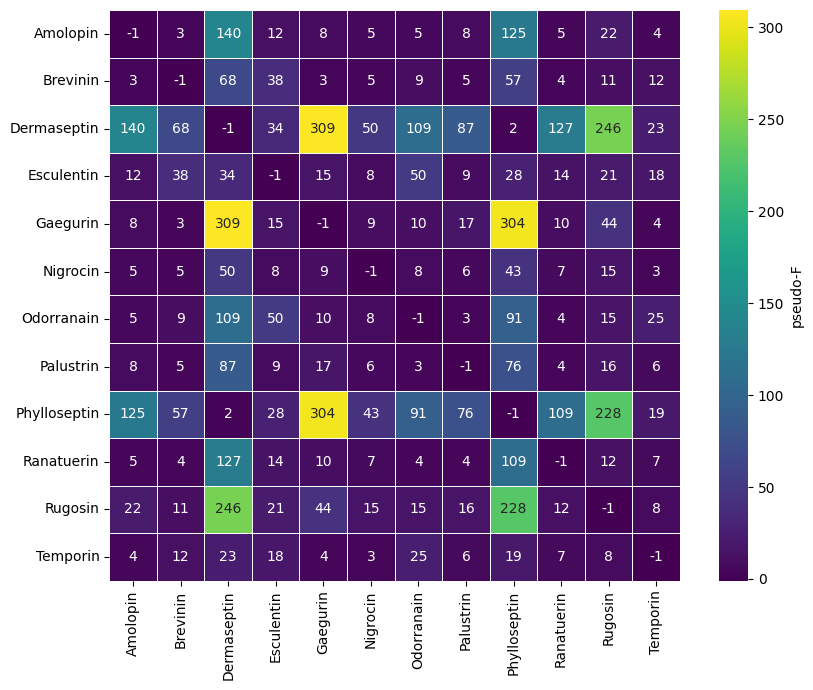

In [16]:
# --- Heatmap de p-values (mantengo decimales) ---
plt.figure(figsize=(9,7))

pseudoF_matrix = pd.DataFrame(np.zeros((len(unique_groups), len(unique_groups))) -1 ,
                              index=unique_groups, columns=unique_groups)


for _, row in pairwise_df.iterrows():
    if row['significant']:
        pseudoF_matrix.loc[row['group1'], row['group2']] = row['pseudo-F']
        pseudoF_matrix.loc[row['group2'], row['group1']] = row['pseudo-F']

pseudoF_int = np.rint(pseudoF_matrix.values).astype(int)    # redondea y convierte a int
annot = pseudoF_int.astype(str)                             # matriz de strings para anotación

plt.figure(figsize=(9,7))
ax2 = sns.heatmap(pseudoF_matrix, annot=annot, fmt='', cmap='viridis',
                  linewidths=.5, linecolor='white',
                  square=True, cbar_kws={'label':'pseudo-F'}
                 )

# 2) forzar formato entero en la barra de color (evita notación científica)
ax2.collections[0].colorbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

plt.savefig('fig/permanova/indexado_alineacion_permanova_heatmap_pseudo-f.png')

#descomentar la siguiente línea para guardar el heatmap de la secuencia
#plt.savefig('fig/permanova/indexado_secuencia_permanova_heatmap_pseudo-f.png')

plt.tight_layout()
plt.show()